# Data Analysis & Time-Series Diagnostics 

This notebook performs statistical analysis and time-series diagnostics on the continuous front-contract returns.

In [7]:
import sys
import os
import logging
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Ensure src is in path
sys.path.append(os.path.abspath('..'))

from src.analysis import (
    predictive_regression,
    calculate_return_stats, calculate_autocorrelation, test_stationarity, calculate_correlations,
    calculate_rolling_stats, perform_pca, check_seasonality, detect_outliers,
    calculate_max_drawdown, calculate_var, calculate_cvar
)

# Configure Logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Configuration
DATA_PATH = Path("../data/processed/master_dataset_with_carry.parquet")
OUTPUT_FILE = Path("../data/processed/continuous_returns.parquet")

# Publication Quality Plots
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 1. Load Data & Reconstruct Front Returns
Load the term structure dataset and reconstruct the continuous front-contract returns using the roll-adjusted logic.

In [8]:

if DATA_PATH.exists():
    df = pd.read_parquet(DATA_PATH)
    print(f"Loaded {len(df):,} rows.")
    
    # Reconstruct front returns (Roll-Adjusted)
    front_rets = (
        df[df['is_front']]
        .pivot(index='date', columns='root', values='return')
        .sort_index()
    )
    
    # Reconstruct front carry
    front_carry = (
        df[df['is_front']]
        .pivot(index='date', columns='root', values='carry')
        .sort_index()
    )
    
    print(f"Front Returns Shape: {front_rets.shape}")
    print(f"Front Carry Shape: {front_carry.shape}")
else:
    print(f"Data file not found at {DATA_PATH}")

Loaded 606,566 rows.
Front Returns Shape: (3111, 28)
Front Carry Shape: (3111, 28)


## 2. Return Distribution Diagnostics (All Assets)
Compute summary statistics for ALL assets to identify potential issues.

In [9]:
stats_df = calculate_return_stats(front_rets)

# Show summary of the universe
print("Universe Summary Statistics:")
display(stats_df.describe())

# Highlight outliers in Kurtosis (Fat tails)
print("\nTop 10 Assets by Kurtosis (Fat Tails):")
display(stats_df.sort_values('kurt', ascending=False).head(10)[['kurt', 'skew', 'ann_vol']])

# Highlight outliers in Volatility
print("\nTop 10 Assets by Annualized Volatility:")
display(stats_df.sort_values('ann_vol', ascending=False).head(10)[['ann_vol', 'sharpe']])

Universe Summary Statistics:


,count,mean,std,min,1%,5%,50%,95%,99%,max,skew,kurt,pct_up,ann_vol,sharpe
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,2974.642857,0.000118,0.011359,-0.085720,-0.029396,-0.017384,0.000011,0.017843,0.030390,0.085455,0.509544,21.673871,0.492075,0.180319,0.081052
std,262.887698,0.000238,0.007453,0.073676,0.018761,0.011202,0.000431,0.011714,0.019914,0.063739,2.482754,82.852478,0.025536,0.118317,0.323994
min,2326.000000,-0.000356,0.000850,-0.340856,-0.076590,-0.048189,-0.001166,0.001233,0.002597,0.009892,-0.523864,1.879257,0.444838,0.013493,-0.477339
25%,3105.000000,-0.000072,0.005576,-0.107739,-0.039461,-0.022447,-0.000141,0.008276,0.014612,0.032223,-0.135926,2.534661,0.475842,0.088523,-0.183948
50%,3109.000000,0.000051,0.010551,-0.065072,-0.030151,-0.016372,0.000000,0.015669,0.026869,0.075855,0.060955,4.979001,0.487721,0.167489,0.014626
75%,3110.000000,0.000288,0.014893,-0.036456,-0.014266,-0.008212,0.000251,0.025322,0.039873,0.103590,0.193360,7.973193,0.507727,0.236424,0.328891
max,3110.000000,0.000551,0.030180,-0.004579,-0.002441,-0.001232,0.000784,0.049209,0.081825,0.225273,13.073110,443.690860,0.550482,0.479094,0.707700



Top 10 Assets by Kurtosis (Fat Tails):


,kurt,skew,ann_vol
root,,,
6S,443.690860,13.073110,0.089710
CL,24.246312,-0.523864,0.402829
ZT,14.111713,0.992467,0.013493
ES,12.380883,-0.135104,0.156275
RB,10.918951,-0.324172,0.367041
HO,9.620728,-0.264569,0.334562
6B,8.745401,-0.431268,0.084960
SI,7.715791,0.141710,0.262029
RTY,7.425181,-0.214429,0.217651



Top 10 Assets by Annualized Volatility:


,ann_vol,sharpe
root,,
NG,0.479094,-0.187189
CL,0.402829,0.126907
RB,0.367041,0.367910
HO,0.334562,0.315030
ZW,0.306430,-0.122446
SI,0.262029,0.261425
ZL,0.256112,0.436352
ZM,0.229862,0.352847
ZC,0.228669,0.127062


## 3. Data Cleaning Feedback Loop: Outlier Detection & Handling
Identify extreme events (>5 sigma). We will **clean** these from the dataset to create a robust "Gold Standard" for research.

Detected 660 outliers (> 5 MAD). Cleaning them...


,date,asset,return,score,method
88,2015-01-15,6S,0.193607,59.511369,mad
612,2023-03-13,ZT,0.009892,23.002008,mad
125,2020-04-21,CL,-0.340856,21.554242,mad
160,2020-03-12,ES,-0.107035,18.552727,mad
127,2020-04-27,CL,-0.262335,16.594808,mad
161,2020-03-13,ES,0.091999,15.803259,mad
259,2022-03-09,HO,-0.223244,15.480739,mad
8,2016-06-24,6B,-0.060277,15.046555,mad
641,2023-12-13,ZT,0.006440,14.976848,mad
620,2023-03-24,ZT,0.006377,14.828478,mad


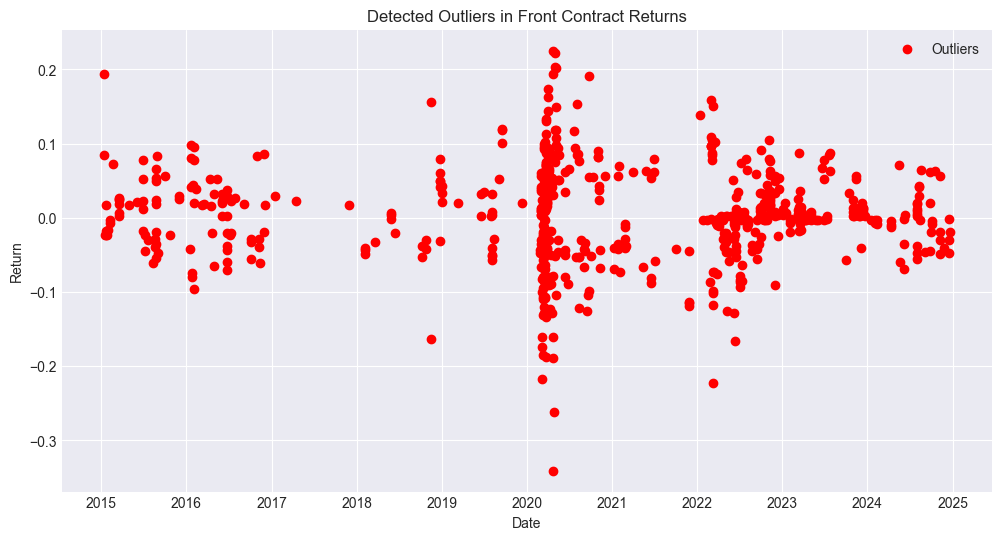

Outliers cleaned (interpolated).
Saved cleaned returns to ../data/processed/continuous_returns.parquet


In [10]:
outliers = detect_outliers(front_rets, threshold=5.0, method='mad')

if not outliers.empty:
    print(f"Detected {len(outliers)} outliers (> 5 MAD). Cleaning them...")
    display(outliers.head(10))
    
    # Visualization of outliers
    plt.figure(figsize=(12, 6))
    plt.scatter(outliers['date'], outliers['return'], c='red', label='Outliers')
    plt.title('Detected Outliers in Front Contract Returns')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend()
    plt.show()
    
    # Clean outliers: Set to NaN and interpolate
    import numpy as np
    clean_rets = front_rets.copy()
    for _, row in outliers.iterrows():
        d = row['date']
        a = row['asset']
        if a in clean_rets.columns and d in clean_rets.index:
            clean_rets.at[d, a] = np.nan
            
    clean_rets = clean_rets.interpolate(method='time')
    print("Outliers cleaned (interpolated).")
else:
    print("No outliers detected.")
    clean_rets = front_rets.copy()

# Save the "Gold Standard" dataset
if not OUTPUT_FILE.parent.exists():
    OUTPUT_FILE.parent.mkdir(parents=True, exist_ok=True)
clean_rets.to_parquet(OUTPUT_FILE)
print(f"Saved cleaned returns to {OUTPUT_FILE}")


## 3b. Advanced Risk Analysis
Calculating Max Drawdown, Value at Risk (VaR), and Conditional VaR (CVaR) for each asset.

Risk Metrics by Asset:


,Max Drawdown,VaR (95%),CVaR (95%)
root,,,
NG,-0.953793,0.048189,0.066840
CL,-0.909363,0.035707,0.057244
RB,-0.789359,0.034668,0.054124
HO,-0.754697,0.031641,0.046924
ZW,-0.698250,0.028681,0.038745
SI,-0.507637,0.024976,0.038026
ZL,-0.433654,0.024295,0.035593
ZC,-0.584982,0.021831,0.032373
RTY,-0.452707,0.020523,0.031944


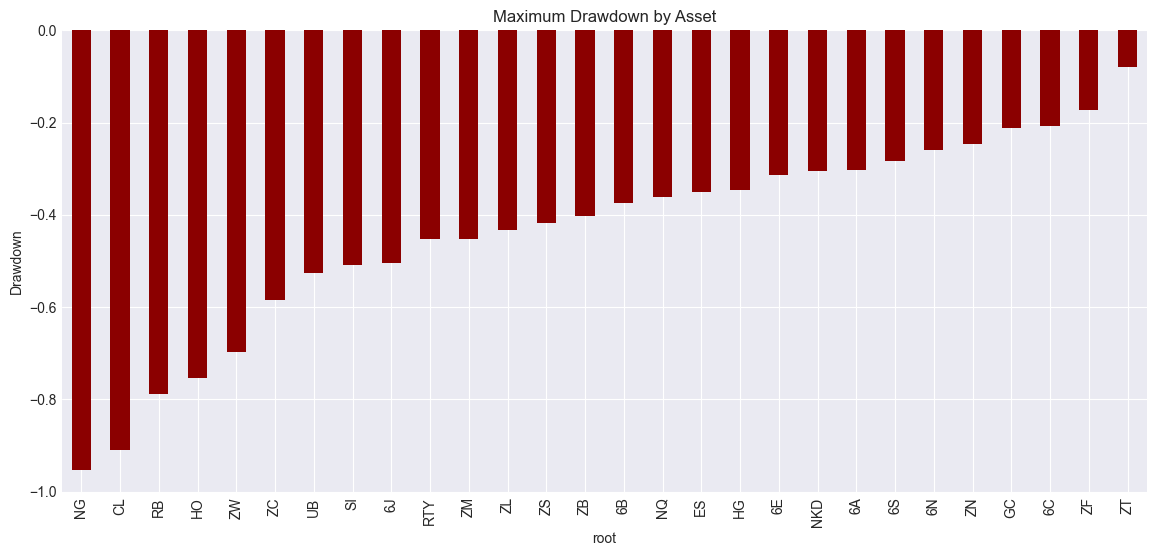

In [11]:
# Calculate Risk Metrics
max_dd = calculate_max_drawdown(front_rets)
var_95 = calculate_var(front_rets, 0.95)
cvar_95 = calculate_cvar(front_rets, 0.95)

risk_df = pd.DataFrame({
    'Max Drawdown': max_dd,
    'VaR (95%)': var_95,
    'CVaR (95%)': cvar_95
}).sort_values('CVaR (95%)', ascending=False)

print("Risk Metrics by Asset:")
display(risk_df)

# Plot Max Drawdown
plt.figure(figsize=(14, 6))
risk_df['Max Drawdown'].sort_values().plot(kind='bar', color='darkred')
plt.title('Maximum Drawdown by Asset')
plt.ylabel('Drawdown')
plt.show()

## 4. Structural Analysis: PCA (On Cleaned Data)
Identify latent factors on the cleaned dataset.

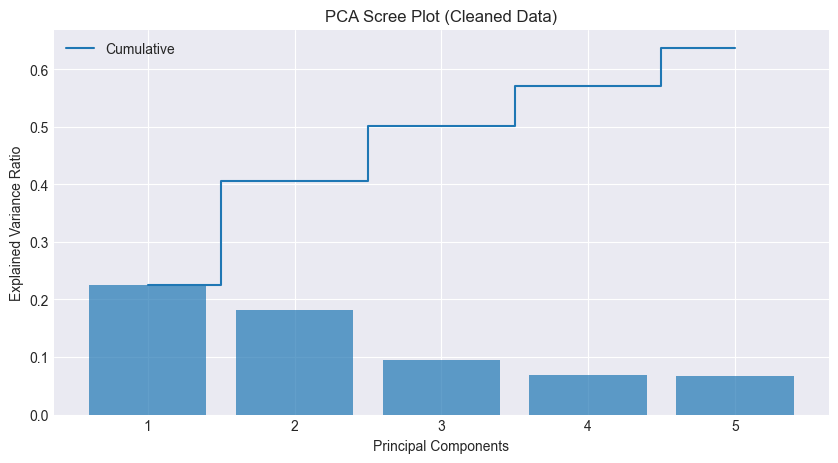

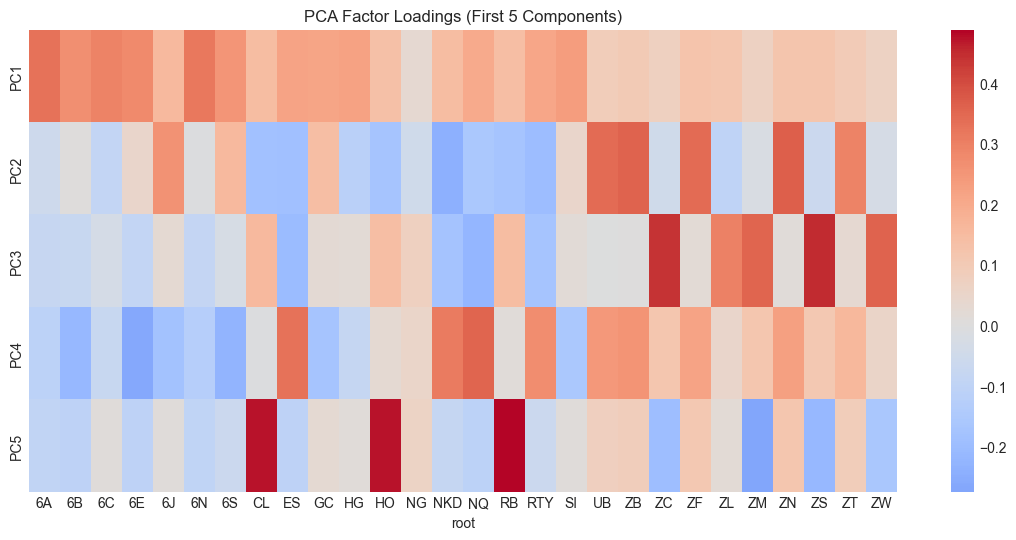

In [12]:
pca_res = perform_pca(clean_rets, n_components=5)

if not pca_res['components'].empty:
    # Scree Plot
    plt.figure(figsize=(10, 5))
    plt.bar(range(1, 6), pca_res['explained_variance_ratio'], alpha=0.7, align='center')
    plt.step(range(1, 6), np.cumsum(pca_res['explained_variance_ratio']), where='mid', label='Cumulative')
    plt.ylabel('Explained Variance Ratio')
    plt.xlabel('Principal Components')
    plt.title('PCA Scree Plot (Cleaned Data)')
    plt.legend(loc='best')
    plt.show()
    
    # Factor Loadings (Heatmap)
    plt.figure(figsize=(14, 6))
    sns.heatmap(pca_res['components'], cmap='coolwarm', center=0, annot=False)
    plt.title('PCA Factor Loadings (First 5 Components)')
    plt.show()

## 5. Dynamic Analysis: Rolling Volatility (All Assets)
Visualize regime shifts across the entire universe.

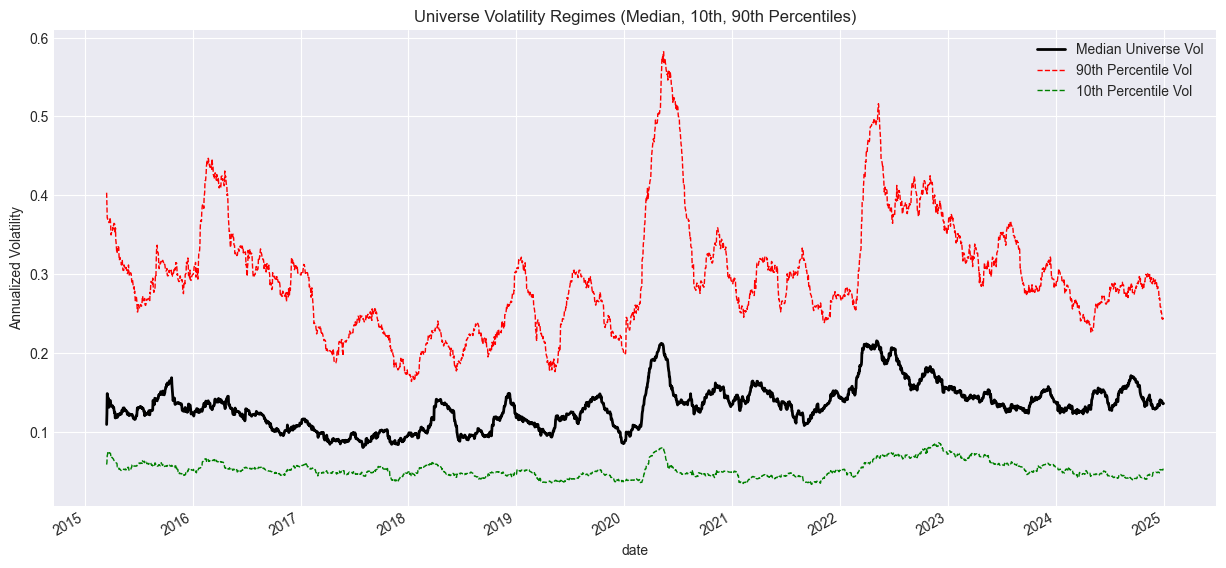

In [13]:
rolling_vol = calculate_rolling_stats(clean_rets, window=63)

# Plot median volatility of the universe to see global regimes
plt.figure(figsize=(15, 7))
rolling_vol.median(axis=1).plot(linewidth=2, color='black', label='Median Universe Vol')
rolling_vol.quantile(0.9, axis=1).plot(linewidth=1, color='red', linestyle='--', label='90th Percentile Vol')
rolling_vol.quantile(0.1, axis=1).plot(linewidth=1, color='green', linestyle='--', label='10th Percentile Vol')

plt.title('Universe Volatility Regimes (Median, 10th, 90th Percentiles)')
plt.ylabel('Annualized Volatility')
plt.legend()
plt.show()

## 6. Save Final Cleaned Data
Save the cleaned, continuous return series. This is the **Gold Standard** dataset for all future modeling.

In [14]:
if not clean_rets.empty:
    try:
        clean_rets.to_parquet(OUTPUT_FILE)
        print(f"Successfully saved cleaned returns to {OUTPUT_FILE}")
        print(f"Shape: {clean_rets.shape}")
    except Exception as e:
        print(f"Error saving data: {e}")

Successfully saved cleaned returns to ../data/processed/continuous_returns.parquet
Shape: (3111, 28)


## 6. Carry Signal Analysis
Analyze the properties of the Carry signal: persistence (autocorrelation), stationarity, and distribution.

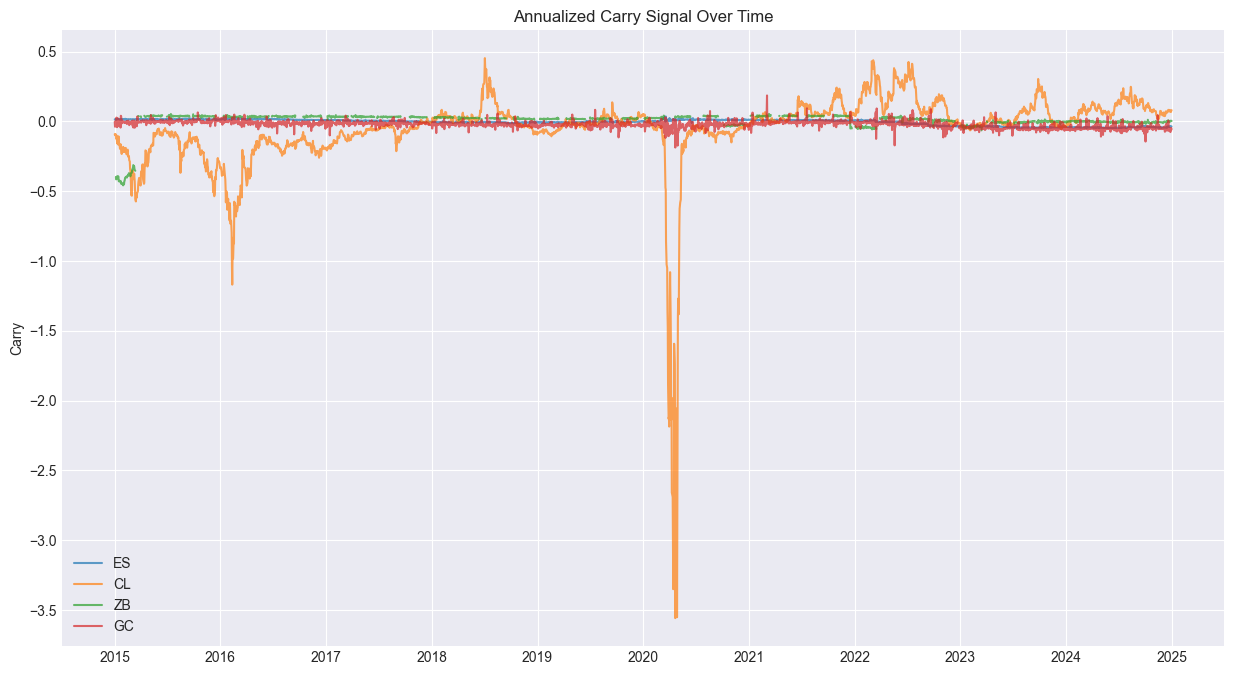


Calculating Carry Signal Autocorrelation...

Carry Signal Autocorrelation (Persistence) - Stats across assets:


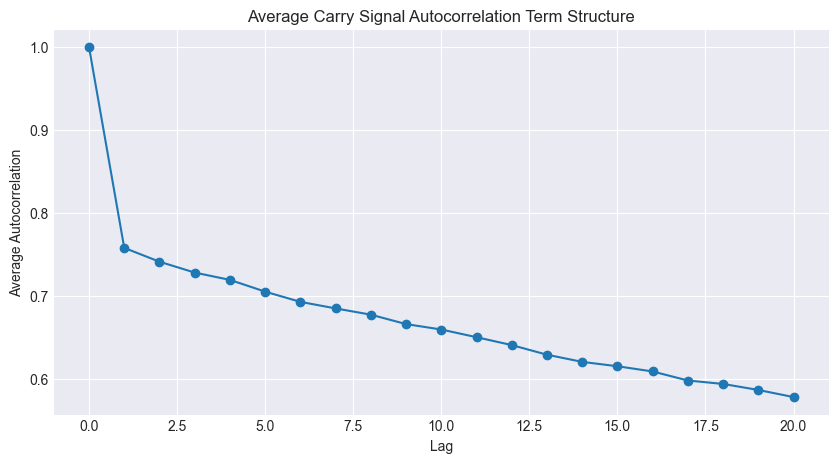

,6A,6B,6C,6E,6J
lag,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.324825,0.258643,0.101410,0.624081,0.776809
2,0.316170,0.235213,0.116771,0.608979,0.764471
3,0.328004,0.207028,0.100709,0.607378,0.764845
4,0.323430,0.195912,0.108168,0.606811,0.772673



Carry Signal Stationarity Tests (ADF & KPSS):


,adf_stat,adf_p,kpss_stat,kpss_p
asset,,,,
6A,-2.910790,4.410760e-02,6.587593,0.01
6B,-3.645146,4.954336e-03,1.892927,0.01
6C,-5.108534,1.347553e-05,1.849262,0.01
6E,-3.190473,2.054282e-02,0.834933,0.01
6J,-1.687534,4.375464e-01,4.097208,0.01
6N,-2.542812,1.054021e-01,4.137939,0.01
6S,-1.718362,4.216774e-01,2.058043,0.01
CL,-6.371727,2.336112e-08,1.665602,0.01
ES,-0.333519,9.206210e-01,5.840674,0.01


In [15]:

# 1. Plot Carry for a few assets
assets_to_plot = ['ES', 'CL', 'ZB', 'GC']
plt.figure(figsize=(15, 8))
for asset in assets_to_plot:
    if asset in front_carry.columns:
        plt.plot(front_carry.index, front_carry[asset], label=asset, alpha=0.7)

plt.title('Annualized Carry Signal Over Time')
plt.ylabel('Carry')
plt.legend()
plt.show()

# 2. Autocorrelation of Carry
print("\nCalculating Carry Signal Autocorrelation...")
acf_data = {}
for asset in front_carry.columns:
    # Calculate for single asset
    res = calculate_autocorrelation(front_carry[asset])
    if not res.empty:
        acf_data[asset] = res['acf']

if acf_data:
    carry_acf_df = pd.DataFrame(acf_data)
    print("\nCarry Signal Autocorrelation (Persistence) - Stats across assets:")
    # Transpose so describe gives stats across assets (columns) for each lag (if we want that) 
    # OR describe on the df gives stats for each asset.
    # Let's show average ACF decay
    mean_acf = carry_acf_df.mean(axis=1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(mean_acf.index, mean_acf.values, marker='o')
    plt.title('Average Carry Signal Autocorrelation Term Structure')
    plt.xlabel('Lag')
    plt.ylabel('Average Autocorrelation')
    plt.grid(True)
    plt.show()
    
    display(carry_acf_df.iloc[:5, :5]) # Show first few lags for first few assets
else:
    print("Could not calculate ACF.")

# 3. Stationarity of Carry
print("\nCarry Signal Stationarity Tests (ADF & KPSS):")
stationarity_results = []
for asset in front_carry.columns:
    res = test_stationarity(front_carry[asset])
    # res is a dict or Series? Let's check src/analysis.py
    # It returns a dict.
    if res:
        res['asset'] = asset
        stationarity_results.append(res)

if stationarity_results:
    carry_stationarity = pd.DataFrame(stationarity_results).set_index('asset')
    display(carry_stationarity.head(10))
else:
    print("Could not calculate stationarity.")

> [!NOTE]
> **Stationarity Test Interpretation**:
> You may observe discrepancies between ADF and KPSS tests.
> - **ADF (Augmented Dickey-Fuller)**: Null hypothesis is a unit root (non-stationary). Low p-value (< 0.05) implies stationarity.
> - **KPSS (Kwiatkowski-Phillips-Schmidt-Shin)**: Null hypothesis is stationarity. Low p-value (< 0.05) implies non-stationarity.
>
> If ADF rejects unit root (Stationary) but KPSS rejects stationarity (Non-Stationary), the series may be difference stationary or have structural breaks.
>
> **Warning Note**: `InterpolationWarning` messages from `statsmodels` regarding p-values have been suppressed in `src/analysis.py` to keep the output clean. The tests return the boundary p-values (0.01 or 0.1) when the statistic is outside the lookup table, which is sufficient for our analysis.

## 6. Predictive Regressions (Nobel-Winning Style)
Test if the Carry signal predicts future returns. We run the regression:
$$ r_{t+1} = \alpha + \beta \times Carry_t + \epsilon_t $$
We look for positive $\beta$ and significant t-statistics.

Preparing data for robust regression...
Running predictive regression with Robust Standard Errors (HAC)...

Regression Results (Top 10 by T-Stat):


,alpha,beta,t_stat,p_value,r_squared
asset,,,,,
ZL,0.000473,0.004237,1.653128,0.098305,0.002036
HO,0.000069,0.003672,1.599792,0.109645,0.001563
ES,0.000553,0.008604,1.245046,0.213115,0.000490
ZM,0.000130,0.001833,0.982182,0.326010,0.000812
CL,0.000230,0.002366,0.764140,0.444784,0.000600
ZN,-0.000087,0.002757,0.665237,0.505899,0.000219
RTY,0.000415,0.009309,0.603334,0.546286,0.000245
6J,-0.000127,0.001252,0.264022,0.791763,0.000029
ZB,-0.000118,0.000438,0.236620,0.812952,0.000026


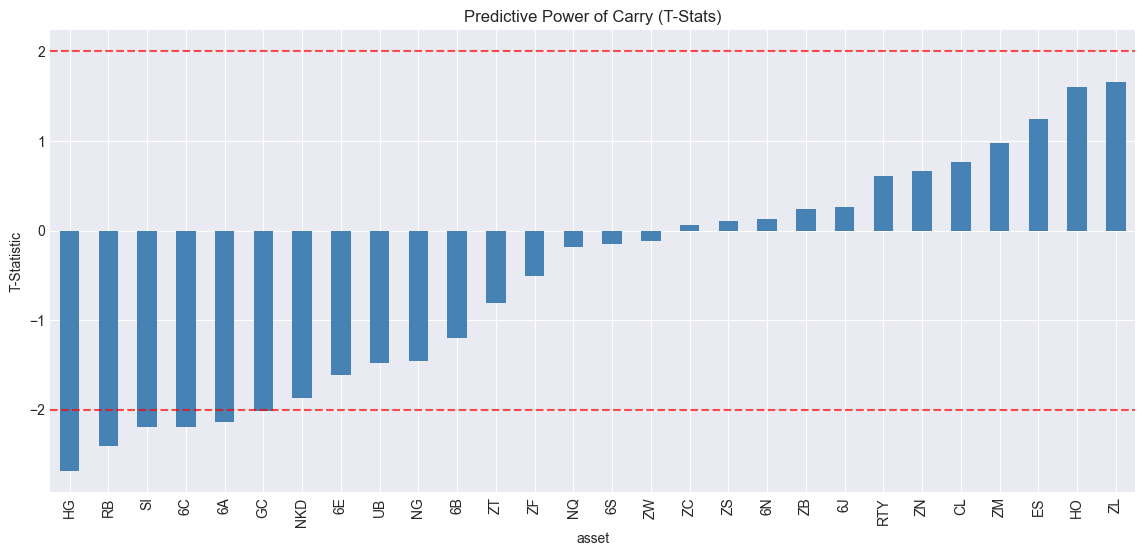

In [16]:
# Robust Predictive Regression
# 1. Use clean_rets (outliers removed) to prevent extreme returns from skewing results.
# 2. Winsorize carry signal (1%/99%) to prevent extreme signal outliers from dominating.

print("Preparing data for robust regression...")

# Winsorize Carry (1% / 99% per asset)
front_carry_robust = front_carry.copy()
for col in front_carry_robust.columns:
    lower = front_carry_robust[col].quantile(0.01)
    upper = front_carry_robust[col].quantile(0.99)
    front_carry_robust[col] = front_carry_robust[col].clip(lower, upper)

print("Running predictive regression with Robust Standard Errors (HAC)...")
reg_results = predictive_regression(front_carry_robust, clean_rets, horizon=1)

print("\nRegression Results (Top 10 by T-Stat):")
display(reg_results.sort_values('t_stat', ascending=False).head(10))

# Plot T-Stats
plt.figure(figsize=(14, 6))
reg_results['t_stat'].sort_values().plot(kind='bar', color='steelblue')
plt.axhline(2.0, color='r', linestyle='--', alpha=0.7)
plt.axhline(-2.0, color='r', linestyle='--', alpha=0.7)
plt.title('Predictive Power of Carry (T-Stats)')
plt.ylabel('T-Statistic')
plt.show()